# Insgesamt Accidents Analysis and Modeling

In this notebook, I proposed a solution for forecasting the 'Insgesamt' category from Verkehrsunfälle accidents type in Munich accidents dataset. In this dataset, there are 4 categories of accidents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Preparing, cleaning, analyzing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 
seed_number = 42
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

## Data Preparation

In [2]:
df = pd.read_csv('./data/clean_munich_accidents.csv', index_col='date')

In [3]:
df.head()

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Fluchtunfälle,Verletzte und Getötete,2000,1,34
2000-01-01,Verkehrsunfälle,mit Personenschäden,2000,1,321
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-01-01,Fluchtunfälle,insgesamt,2000,1,835
2000-01-01,Verkehrsunfälle,insgesamt,2000,1,3448


In [4]:
#Extracting the Alkoholunfälle
df = df[df.category == 'Alkoholunfälle']

In [5]:
#Extracting the insgesamt data

df = df[df.accident_type == 'insgesamt']

## Data Assesment

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       252 non-null    object
 1   accident_type  252 non-null    object
 2   year           252 non-null    int64 
 3   month          252 non-null    int64 
 4   value          252 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.8+ KB


In [7]:
df.head(15)

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-02-01,Alkoholunfälle,insgesamt,2000,2,53
2000-03-01,Alkoholunfälle,insgesamt,2000,3,73
2000-04-01,Alkoholunfälle,insgesamt,2000,4,78
2000-05-01,Alkoholunfälle,insgesamt,2000,5,96
2000-06-01,Alkoholunfälle,insgesamt,2000,6,57
2000-07-01,Alkoholunfälle,insgesamt,2000,7,99
2000-08-01,Alkoholunfälle,insgesamt,2000,8,77
2000-09-01,Alkoholunfälle,insgesamt,2000,9,84


In [8]:
df.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Here, All the values are proper Numbers except the 1st value

In [9]:
df.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

Year column has incorrect datatype

In [10]:

df.accident_type.unique()

array(['insgesamt'], dtype=object)

## Cleaning
From above analysis I decided the follwoing:
- Remove accident_type, and category columns.
- Sort the values to have a sorted values according to the date column.

### Remove accident_type, category

In [11]:
df.drop(columns=['accident_type', 'category'], inplace=True, axis=1)

### Sorting values accordiing to the date

In [12]:
df.sort_values(['date'], inplace=True, ascending=True)

In [13]:
# save the data to be used in prediction
df.to_csv('./data/Alko_Insg.csv')

## Preprocessing

- Splitting Data into training and testing.
- Data Normalization.
- Preparing LSTM subsequences

### Splitting Data into training and testing

In [19]:
df

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
...,...,...,...
2020-08-01,2020,8,46
2020-09-01,2020,9,46
2020-10-01,2020,10,34


In [20]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
train, test = train_test_split(df, test_size=0.1, shuffle = False)



In [21]:
train[0:20]

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
2000-06-01,2000,6,57
2000-07-01,2000,7,99
2000-08-01,2000,8,77
2000-09-01,2000,9,84


In [22]:
test.head()

,year,month,value
date,,,
2018-11-01,2018,11,31
2018-12-01,2018,12,21
2019-01-01,2019,1,22
2019-02-01,2019,2,28
2019-03-01,2019,3,34


In [23]:
train.shape, test.shape

((226, 3), (26, 3))

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 2000-01-01 to 2018-10-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    226 non-null    int64
 1   month   226 non-null    int64
 2   value   226 non-null    int64
dtypes: int64(3)
memory usage: 7.1+ KB


### Data Normalization

In [25]:
f_scaler = RobustScaler()
cnt_scaler = RobustScaler()

#Features columns
f_columns = ['year', 'month']


# Fit the training
f_transformer = f_scaler.fit(train[f_columns].to_numpy())

#Transform the training
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())


cnt__transformer = cnt_scaler.fit(train[['value']])
#For output column
train['value'] = cnt__transformer.transform(train[['value']])
test['value'] = cnt__transformer.transform(test[['value']])


In [26]:
import pickle
#Saving the scalers to pickle file to be used in inferrence
with open('./scalers/f_transformer.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(f_transformer, file)
    
with open('./scalers/cnt_transformer.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(cnt__transformer, file)    

### Preparing LSTM subsequences

In [27]:
def creat_ds(x,y, time_step=1):
    #Create x series and y series to hold sequences
    xs, ys = [], []
    
    for i in range(len(x) - time_step):
        #Extract the sequence
        v = x.iloc[i: (i+time_step)].to_numpy()
        #append it into x series
        xs.append(v)
        
        #Repeat all above for y series
        ys.append(y.iloc[i+time_step])
    return np.array(xs), np.array(ys)   
    

In [28]:
#I will use the previous 5 months data to know the future data
#['category', 'accident_type', 'year', 'month']
Time_Step = 12
xs_train, ys_train = creat_ds(train, train.value, time_step=Time_Step)


xs_test, ys_test = creat_ds(test, test.value, time_step=Time_Step)

In [29]:
xs_train.shape, xs_test.shape

((214, 12, 3), (14, 12, 3))

In [30]:
ys_train.shape, ys_test.shape 

((214,), (14,))

In [31]:
xs_train.shape[1],xs_train.shape[2] 

(12, 3)

In [32]:
xs_train[0]

array([[-0.9       , -0.86956522,  1.5       ],
       [-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667]])

In [34]:
ys_train[0]

1.0

In [33]:
xs_train[1]

array([[-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667],
       [-0.8       , -0.86956522,  1.        ]])

In [34]:
ys_train[1]

0.2916666666666667

In [35]:
xs_train[2]

array([[-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667],
       [-0.8       , -0.86956522,  1.        ],
       [-0.8       , -0.69565217,  0.29166667]])

## Modeling

In [35]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_copy_model.h5', monitor='val_loss', mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

model = keras.Sequential()
model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64,input_shape = (xs_train.shape[1], xs_train.shape[2]))))

model.add(tf.keras.layers.Dense(units=1))

In [36]:
model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(0.00001))

In [37]:
history = model.fit(xs_train, ys_train, epochs=10000, batch_size=4, validation_split=0.25,
                    shuffle=False, callbacks=[mc, es])

Epoch 1/10000
40/40 [==============================] - 3s 33ms/step - loss: 0.7121 - val_loss: 0.4654

Epoch 00001: saving model to best_copy_model.h5
Epoch 2/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.7000 - val_loss: 0.4574

Epoch 00002: saving model to best_copy_model.h5
Epoch 3/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.6880 - val_loss: 0.4491

Epoch 00003: saving model to best_copy_model.h5
Epoch 4/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.6757 - val_loss: 0.4408

Epoch 00004: saving model to best_copy_model.h5
Epoch 5/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.6635 - val_loss: 0.4326

Epoch 00005: saving model to best_copy_model.h5
Epoch 6/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.6513 - val_loss: 0.4246

Epoch 00006: saving model to best_copy_model.h5
Epoch 7/10000
40/40 [==============================] - 2s 50ms/step - loss: 0.6393 - val_loss:

40/40 [==============================] - 3s 67ms/step - loss: 0.2892 - val_loss: 0.1863

Epoch 00055: saving model to best_copy_model.h5
Epoch 56/10000
40/40 [==============================] - 3s 70ms/step - loss: 0.2868 - val_loss: 0.1844

Epoch 00056: saving model to best_copy_model.h5
Epoch 57/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.2845 - val_loss: 0.1826

Epoch 00057: saving model to best_copy_model.h5
Epoch 58/10000
40/40 [==============================] - 2s 50ms/step - loss: 0.2824 - val_loss: 0.1808

Epoch 00058: saving model to best_copy_model.h5
Epoch 59/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.2804 - val_loss: 0.1792

Epoch 00059: saving model to best_copy_model.h5
Epoch 60/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.2785 - val_loss: 0.1776

Epoch 00060: saving model to best_copy_model.h5
Epoch 61/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.2767 - val_loss: 0.1761


40/40 [==============================] - 2s 43ms/step - loss: 0.2223 - val_loss: 0.1397

Epoch 00109: saving model to best_copy_model.h5
Epoch 110/10000
40/40 [==============================] - 2s 44ms/step - loss: 0.2214 - val_loss: 0.1393

Epoch 00110: saving model to best_copy_model.h5
Epoch 111/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2205 - val_loss: 0.1390

Epoch 00111: saving model to best_copy_model.h5
Epoch 112/10000
40/40 [==============================] - 3s 77ms/step - loss: 0.2196 - val_loss: 0.1386

Epoch 00112: saving model to best_copy_model.h5
Epoch 113/10000
40/40 [==============================] - 2s 56ms/step - loss: 0.2187 - val_loss: 0.1382

Epoch 00113: saving model to best_copy_model.h5
Epoch 114/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.2178 - val_loss: 0.1379

Epoch 00114: saving model to best_copy_model.h5
Epoch 115/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.2169 - val_loss: 0


Epoch 00162: saving model to best_copy_model.h5
Epoch 163/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1770 - val_loss: 0.1266

Epoch 00163: saving model to best_copy_model.h5
Epoch 164/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1762 - val_loss: 0.1264

Epoch 00164: saving model to best_copy_model.h5
Epoch 165/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1755 - val_loss: 0.1263

Epoch 00165: saving model to best_copy_model.h5
Epoch 166/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1747 - val_loss: 0.1261

Epoch 00166: saving model to best_copy_model.h5
Epoch 167/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1740 - val_loss: 0.1259

Epoch 00167: saving model to best_copy_model.h5
Epoch 168/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1732 - val_loss: 0.1258

Epoch 00168: saving model to best_copy_model.h5
Epoch 169/10000
40/40 [==========


Epoch 00269: saving model to best_copy_model.h5
Epoch 270/10000
40/40 [==============================] - 5s 120ms/step - loss: 0.1303 - val_loss: 0.1112

Epoch 00270: saving model to best_copy_model.h5
Epoch 271/10000
40/40 [==============================] - 6s 139ms/step - loss: 0.1302 - val_loss: 0.1111

Epoch 00271: saving model to best_copy_model.h5
Epoch 272/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1301 - val_loss: 0.1110

Epoch 00272: saving model to best_copy_model.h5
Epoch 273/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1300 - val_loss: 0.1109

Epoch 00273: saving model to best_copy_model.h5
Epoch 274/10000
40/40 [==============================] - 2s 40ms/step - loss: 0.1299 - val_loss: 0.1108

Epoch 00274: saving model to best_copy_model.h5
Epoch 275/10000
40/40 [==============================] - 2s 47ms/step - loss: 0.1298 - val_loss: 0.1107

Epoch 00275: saving model to best_copy_model.h5
Epoch 276/10000
40/40 [========


Epoch 00376: saving model to best_copy_model.h5
Epoch 377/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1264 - val_loss: 0.1031

Epoch 00377: saving model to best_copy_model.h5
Epoch 378/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1264 - val_loss: 0.1030

Epoch 00378: saving model to best_copy_model.h5
Epoch 379/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1264 - val_loss: 0.1030

Epoch 00379: saving model to best_copy_model.h5
Epoch 380/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1264 - val_loss: 0.1029

Epoch 00380: saving model to best_copy_model.h5
Epoch 381/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1263 - val_loss: 0.1029

Epoch 00381: saving model to best_copy_model.h5
Epoch 382/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1263 - val_loss: 0.1028

Epoch 00382: saving model to best_copy_model.h5
Epoch 383/10000
40/40 [==========


Epoch 00483: saving model to best_copy_model.h5
Epoch 484/10000
40/40 [==============================] - 3s 82ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00484: saving model to best_copy_model.h5
Epoch 485/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1249 - val_loss: 0.0999

Epoch 00485: saving model to best_copy_model.h5
Epoch 486/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1249 - val_loss: 0.0998

Epoch 00486: saving model to best_copy_model.h5
Epoch 487/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1249 - val_loss: 0.0998

Epoch 00487: saving model to best_copy_model.h5
Epoch 488/10000
40/40 [==============================] - 2s 62ms/step - loss: 0.1249 - val_loss: 0.0998

Epoch 00488: saving model to best_copy_model.h5
Epoch 489/10000
40/40 [==============================] - 3s 65ms/step - loss: 0.1248 - val_loss: 0.0998

Epoch 00489: saving model to best_copy_model.h5
Epoch 490/10000
40/40 [==========


Epoch 00590: saving model to best_copy_model.h5
Epoch 591/10000
40/40 [==============================] - 3s 88ms/step - loss: 0.1237 - val_loss: 0.0985

Epoch 00591: saving model to best_copy_model.h5
Epoch 592/10000
40/40 [==============================] - 2s 44ms/step - loss: 0.1237 - val_loss: 0.0984

Epoch 00592: saving model to best_copy_model.h5
Epoch 593/10000
40/40 [==============================] - 3s 81ms/step - loss: 0.1237 - val_loss: 0.0984

Epoch 00593: saving model to best_copy_model.h5
Epoch 594/10000
40/40 [==============================] - 2s 48ms/step - loss: 0.1236 - val_loss: 0.0984

Epoch 00594: saving model to best_copy_model.h5
Epoch 595/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1236 - val_loss: 0.0984

Epoch 00595: saving model to best_copy_model.h5
Epoch 596/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1236 - val_loss: 0.0984

Epoch 00596: saving model to best_copy_model.h5
Epoch 597/10000
40/40 [==========


Epoch 00697: saving model to best_copy_model.h5
Epoch 698/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00698: saving model to best_copy_model.h5
Epoch 699/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00699: saving model to best_copy_model.h5
Epoch 700/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00700: saving model to best_copy_model.h5
Epoch 701/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00701: saving model to best_copy_model.h5
Epoch 702/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00702: saving model to best_copy_model.h5
Epoch 703/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1226 - val_loss: 0.0976

Epoch 00703: saving model to best_copy_model.h5
Epoch 704/10000
40/40 [==========


Epoch 00804: saving model to best_copy_model.h5
Epoch 805/10000
40/40 [==============================] - 2s 56ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00805: saving model to best_copy_model.h5
Epoch 806/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00806: saving model to best_copy_model.h5
Epoch 807/10000
40/40 [==============================] - 2s 48ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00807: saving model to best_copy_model.h5
Epoch 808/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00808: saving model to best_copy_model.h5
Epoch 809/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00809: saving model to best_copy_model.h5
Epoch 810/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1216 - val_loss: 0.0969

Epoch 00810: saving model to best_copy_model.h5
Epoch 811/10000
40/40 [==========


Epoch 00911: saving model to best_copy_model.h5
Epoch 912/10000
40/40 [==============================] - 2s 52ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00912: saving model to best_copy_model.h5
Epoch 913/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00913: saving model to best_copy_model.h5
Epoch 914/10000
40/40 [==============================] - 3s 70ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00914: saving model to best_copy_model.h5
Epoch 915/10000
40/40 [==============================] - 2s 47ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00915: saving model to best_copy_model.h5
Epoch 916/10000
40/40 [==============================] - 2s 44ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00916: saving model to best_copy_model.h5
Epoch 917/10000
40/40 [==============================] - 2s 52ms/step - loss: 0.1207 - val_loss: 0.0964

Epoch 00917: saving model to best_copy_model.h5
Epoch 918/10000
40/40 [==========

40/40 [==============================] - 1s 35ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01018: saving model to best_copy_model.h5
Epoch 1019/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01019: saving model to best_copy_model.h5
Epoch 1020/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01020: saving model to best_copy_model.h5
Epoch 1021/10000
40/40 [==============================] - 1s 38ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01021: saving model to best_copy_model.h5
Epoch 1022/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01022: saving model to best_copy_model.h5
Epoch 1023/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1199 - val_loss: 0.0959

Epoch 01023: saving model to best_copy_model.h5
Epoch 1024/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.1199 - val_l

40/40 [==============================] - 1s 35ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01124: saving model to best_copy_model.h5
Epoch 1125/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1192 - val_loss: 0.0955

Epoch 01125: saving model to best_copy_model.h5
Epoch 1126/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1192 - val_loss: 0.0954

Epoch 01126: saving model to best_copy_model.h5
Epoch 1127/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1192 - val_loss: 0.0954

Epoch 01127: saving model to best_copy_model.h5
Epoch 1128/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1191 - val_loss: 0.0954

Epoch 01128: saving model to best_copy_model.h5
Epoch 1129/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1191 - val_loss: 0.0954

Epoch 01129: saving model to best_copy_model.h5
Epoch 1130/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1191 - val_l

40/40 [==============================] - 1s 36ms/step - loss: 0.1185 - val_loss: 0.0951

Epoch 01230: saving model to best_copy_model.h5
Epoch 1231/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01231: saving model to best_copy_model.h5
Epoch 1232/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01232: saving model to best_copy_model.h5
Epoch 1233/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01233: saving model to best_copy_model.h5
Epoch 1234/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01234: saving model to best_copy_model.h5
Epoch 1235/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1184 - val_loss: 0.0951

Epoch 01235: saving model to best_copy_model.h5
Epoch 1236/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1184 - val_l

40/40 [==============================] - 1s 35ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01336: saving model to best_copy_model.h5
Epoch 1337/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01337: saving model to best_copy_model.h5
Epoch 1338/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01338: saving model to best_copy_model.h5
Epoch 1339/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1178 - val_loss: 0.0947

Epoch 01339: saving model to best_copy_model.h5
Epoch 1340/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1177 - val_loss: 0.0947

Epoch 01340: saving model to best_copy_model.h5
Epoch 1341/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1177 - val_loss: 0.0947

Epoch 01341: saving model to best_copy_model.h5
Epoch 1342/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1177 - val_l

40/40 [==============================] - 1s 35ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01442: saving model to best_copy_model.h5
Epoch 1443/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01443: saving model to best_copy_model.h5
Epoch 1444/10000
40/40 [==============================] - 2s 39ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01444: saving model to best_copy_model.h5
Epoch 1445/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01445: saving model to best_copy_model.h5
Epoch 1446/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01446: saving model to best_copy_model.h5
Epoch 1447/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1171 - val_loss: 0.0945

Epoch 01447: saving model to best_copy_model.h5
Epoch 1448/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1171 - val_l

40/40 [==============================] - 2s 40ms/step - loss: 0.1165 - val_loss: 0.0943

Epoch 01548: saving model to best_copy_model.h5
Epoch 1549/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01549: saving model to best_copy_model.h5
Epoch 1550/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01550: saving model to best_copy_model.h5
Epoch 1551/10000
40/40 [==============================] - 1s 38ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01551: saving model to best_copy_model.h5
Epoch 1552/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01552: saving model to best_copy_model.h5
Epoch 1553/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.1165 - val_loss: 0.0942

Epoch 01553: saving model to best_copy_model.h5
Epoch 1554/10000
40/40 [==============================] - 1s 31ms/step - loss: 0.1165 - val_l

40/40 [==============================] - 1s 35ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01654: saving model to best_copy_model.h5
Epoch 1655/10000
40/40 [==============================] - 2s 41ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01655: saving model to best_copy_model.h5
Epoch 1656/10000
40/40 [==============================] - 2s 39ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01656: saving model to best_copy_model.h5
Epoch 1657/10000
40/40 [==============================] - 2s 42ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01657: saving model to best_copy_model.h5
Epoch 1658/10000
40/40 [==============================] - 2s 40ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01658: saving model to best_copy_model.h5
Epoch 1659/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.1159 - val_loss: 0.0941

Epoch 01659: saving model to best_copy_model.h5
Epoch 1660/10000
40/40 [==============================] - 2s 39ms/step - loss: 0.1159 - val_l

40/40 [==============================] - 2s 44ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01760: saving model to best_copy_model.h5
Epoch 1761/10000
40/40 [==============================] - 2s 41ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01761: saving model to best_copy_model.h5
Epoch 1762/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01762: saving model to best_copy_model.h5
Epoch 1763/10000
40/40 [==============================] - 2s 42ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01763: saving model to best_copy_model.h5
Epoch 1764/10000
40/40 [==============================] - 2s 40ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01764: saving model to best_copy_model.h5
Epoch 1765/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1153 - val_loss: 0.0940

Epoch 01765: saving model to best_copy_model.h5
Epoch 1766/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.1153 - val_l

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


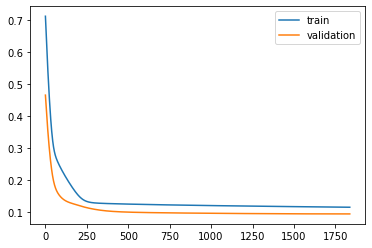

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [40]:
y_predict = model.predict(xs_test)

In [41]:
y_predict

array([[-0.66139734],
       [-0.88334596],
       [-1.0841733 ],
       [-1.0087359 ],
       [-0.8117891 ],
       [-0.60486585],
       [-0.40871355],
       [-0.26170245],
       [-0.20237951],
       [-0.23697564],
       [-0.34695268],
       [-0.51610124],
       [-0.7281809 ],
       [-0.9391569 ]], dtype=float32)

In [42]:
y_train_inv = cnt__transformer.inverse_transform(ys_train.reshape(1, -1))
y_test_inv = cnt__transformer.inverse_transform(ys_test.reshape(1, -1))
y_pred_inv = cnt__transformer.inverse_transform(y_predict)

In [43]:
y_pred_inv

array([[26.126465],
       [20.799698],
       [15.979839],
       [17.790339],
       [22.517061],
       [27.48322 ],
       [32.190876],
       [35.71914 ],
       [37.14289 ],
       [36.312584],
       [33.673134],
       [29.613571],
       [24.523659],
       [19.460236]], dtype=float32)

In [44]:
y_test_inv

array([[29., 35., 28., 40., 27., 26., 40., 49., 58., 46., 46., 34., 23.,
        13.]])